In [ ]:
# Distributed under the MIT License.
# See LICENSE.txt for details.

# Dependencies:
%pip install numpy matplotlib pandas 'h5py>=3.0.0' ruamel.yaml

In [2]:
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
from ruamel.yaml import YAML

In [3]:
%%bash
# Clean up output files from previous runs
rm -f Bbh*.h5

# Binary black hole initial data

In this example we run the elliptic solver to compute initial data for binary
black holes.

First, make sure you have compiled the `SolveXcts` executable. Put in the path
to your build directory below. Make sure you have compiled in `Release` mode.

In [4]:
SPECTRE_BUILD_DIR = "/Users/nlf/Work/spectre/build-Default-Release"
SPECTRE_HOME = "/Users/nlf/Projects/spectre/develop"


## Setup input file

We set up an input file based on the
`tests/InputFiles/Xcts/BinaryBlackHole.yaml` example:

In [5]:
# Load example input file
load_input_file_path = os.path.join(
    SPECTRE_HOME, 'tests/InputFiles/Xcts/BinaryBlackHole.yaml')
yaml = YAML()
with open(load_input_file_path, 'r') as open_input_file:
    input_file = yaml.load(open_input_file)

# Modify example input file
# - Set output file names
input_file['Observers']['VolumeFileName'] = 'BbhVolume'
input_file['Observers']['ReductionFileName'] = 'BbhReductions'

# Write modified input file
with open('Bbh.yaml', 'w') as open_input_file:
    yaml.dump(input_file, open_input_file)

## Run executable

We pass the input file to the `SolveXcts` executable to solve the elliptic
problem. It will take a few minutes to complete on ~10 cores. Adapt the command
below to your system, or run the `SolveXcts` executable with the `Bbh.yaml`
input file manually.

In [6]:
NUM_CORES = multiprocessing.cpu_count()
SOLVE_XCTS = os.path.join(SPECTRE_BUILD_DIR, 'bin/SolveXcts')
!{SOLVE_XCTS} --input-file Bbh.yaml +p {NUM_CORES}

Charm++: standalone mode (not using charmrun)
Charm++> Running in Multicore mode: 12 threads (PEs)
Converse/Charm++ Commit ID: v6.10.2-0-g7bf00fa
Warning> Randomization of virtual memory (ASLR) is turned on in the kernel, thread migration may not work! Run 'echo 0 > /proc/sys/kernel/randomize_va_space' as root to disable it, or try running with '+isomalloc_sync'.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (12 sockets x 1 cores x 1 PUs = 12-way SMP)
Charm++> cpu topology info is gathered in 0.002 seconds.

Executing '/Users/nlf/Work/spectre/build-Default-Release/bin/SolveXcts' using 12 processors.
Charm++ startup time in seconds: 3.621687
Date and time at startup: Tue Feb 22 15:08:18 2022

SpECTRE Build Information:
Version:                      2022.02.17
Compiled on host:             98c21919c2ac
Compiled in directory:        /Users/nlf/Work/spectre/build-Default-Release
Source directory is:          /Users/nlf/Projects/spectre/develop
Compiled on gi

## Load initial data into evolutions

The executable has created H5 output files with volume data and diagnostics:

In [7]:
!ls *.h5

BbhReductions.h5  BbhVolume0.h5


The volume data in the `BbhVolume*.h5` files (one per node) can be imported into
evolution executables. It contains the following data:

In [8]:
!h5ls -r BbhVolume*.h5

/                        Group
/VolumeData.vol          Group
/VolumeData.vol/ObservationId1423324405707320626 Group
/VolumeData.vol/ObservationId1423324405707320626/ConformalFactor Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_xx Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_yx Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_yy Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_zx Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_zy Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/ExtrinsicCurvature_zz Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/HamiltonianConstraint Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/InertialCoordinates_x Dataset {61344}
/VolumeData.vol/ObservationId1423324405707320626/InertialCoordinates_y Dataset {61344}
/VolumeData.vol/Obs

- `Lapse` ($\alpha$), `Shift` ($\beta^i$), `SpatialMetric` ($\gamma_{ij}$) and
  `ExtrinsicCurvature` ($K_{ij}$): These quantities solve the Einstein
  constraint equations in "corotating" coordinates, such that, e.g.,
  $\partial_t K = 0$. The black holes remain approximately at the same
  coordinate positions when starting to evolve the initial data in these
  coordinates. Note that $\beta^i \propto r$ in these coordinates, which can be
  large and hence numerically undesireable.
- `ShiftExcess` ($\beta_\text{excess}^i$): This shift vector excludes the
  rotational part, so it is asymptotically small. Import `ShiftExcess` instead
  of `Shift` in an evolution to obtain coordinates in which the black holes are
  orbiting. Note that only
  $$\begin{equation}
    \beta^i = \beta_\text{background}^i + \beta_\text{excess}^i
  \end{equation}$$
  fulfills all coordinate conditions imposed on the initial data, such as
  $\partial_t K = 0$. The background shift is typically
  $$\begin{equation}
    \beta_\text{background}^i = \epsilon^{ijk} \Omega^{j} x^k + \dot{a}_0 x^i
    \text{,}
  \end{equation}$$
  where $\Omega$ is the orbital angular velocity and $\dot{a}_0$ is the
  expansion parameter.
  See the [Xcts::AnalyticData::Binary](https://spectre-code.org/classXcts_1_1AnalyticData_1_1Binary.html)
  class for details.

## Plot diagnostics

We plot the diagnostics in `BbhReductions.h5` to see what happened during the
elliptic solve:

In [9]:
# These routines read the data and process them a bit. You can skip to the plot
# below to see the results.

def split_iteration_sequence(data):
    left_bounds = np.where(data.index == 0)[0]
    right_bounds = list(left_bounds[1:]) + [-1]
    return [data.iloc[i:j] for i, j in zip(left_bounds, right_bounds)]


def load_dataset(subfile):
    legend = subfile.attrs['Legend']
    return pd.DataFrame(data=subfile, columns=legend).set_index(legend[0])


with h5py.File('BbhReductions.h5', 'r') as h5_file:
    nonlinear_residuals = load_dataset(h5_file['NewtonRaphsonResiduals.dat'])
    all_linear_residuals = split_iteration_sequence(
        load_dataset(h5_file['GmresResiduals.dat']))

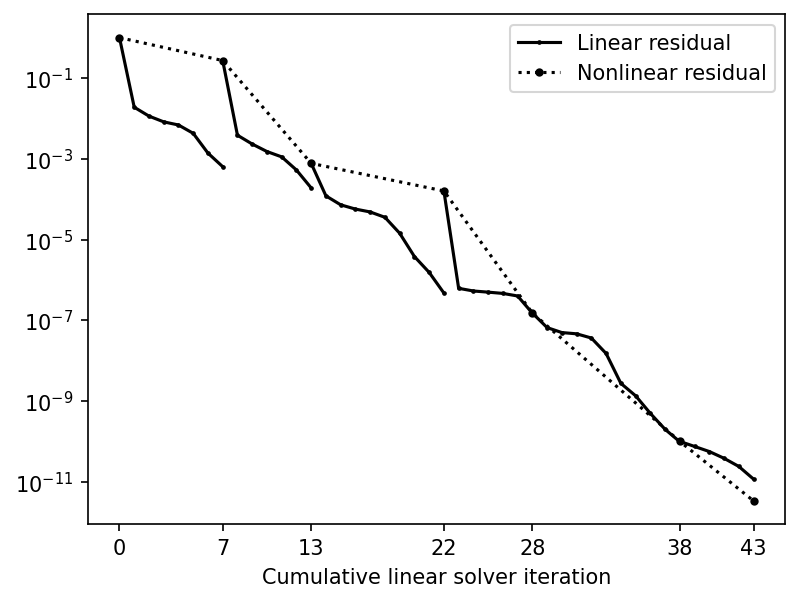

In [10]:
plt.figure(figsize=(6, 4.5), dpi=150)

# Plot linear residuals
n = 0
lin_label = "Linear residual"
for linear_residuals in all_linear_residuals:
    plt.semilogy(
        linear_residuals.index + n,
        linear_residuals["Residual"] /
        all_linear_residuals[0]["Residual"].iloc[0],
        color="black",
        label=lin_label,
        marker='.',
        markersize=2.5,
        zorder=30,
    )
    n += len(linear_residuals) - 1
    lin_label = None

# Plot nonlinear residuals
nonlin_xticks = [0] + list(
    np.cumsum([len(l) - 1 for l in all_linear_residuals]))
plt.semilogy(
    nonlin_xticks,
    nonlinear_residuals["Residual"] / nonlinear_residuals["Residual"].iloc[0],
    color="black",
    ls="dotted",
    marker=".",
    label="Nonlinear residual",
    zorder=40,
)
plt.xticks(nonlin_xticks)
xticks = range(len(
    all_linear_residuals)) if nonlinear_residuals is None else nonlin_xticks

plt.xlabel("Cumulative linear solver iteration")
plt.legend();

The plot shows the convergence of the nonlinear solver (dotted line), along with
the convergence of the linear solver that runs in each nonlinear iteration
(solid line). A few things to note:

- The residual converges down to almost machine precision, but that doesn't
  reflect the discretization error of the solution. It only shows that we have
  solved the discretized problem very accurately. To get an idea of the
  discretization error we would have to look at quantities such as constraint
  norms.
- The Newton-Raphson nonlinear solver converges slowly at first, and then begins
  to converge quadratically once we are closer to the solution and hence the
  linearization is more accurate.
- The linear solver needs only a few steps to converge, which is a feature of
  our multigrid-Schwarz preconditioner.

You can read more about the elliptic solver in this paper:

- N. L. Vu _et al_., A scalable elliptic solver with task-based parallelism for
  the SpECTRE numerical relativity code (2022),
  [arXiv:2111.06767](https://arxiv.org/abs/2111.06767)